## 1. Identification of Frost in Martian HiRISE Images1

### (a) In this problem, we are trying to build a classifier that distinguishes images of Martian terrain with frost. This dataset was created to study Mars’ seasonal frost cycle and its role in the planet’s climate and surface evolution over the past 2 billion years. The data helps in identifying low-latitude frosted microclimates and their impact on climate.

### (b) Data Exploration and Pre-processing
#### i. Images (png files) and labels (json files) are organized in the data directory by “subframes.” Subframes are individual 5120x5120 pixel images which are crops of the original HiRISE images (often on the order of 50k x 10k pixels). Individual subframes were annotated by the contributors and then sliced into 299x299 “tiles.” Each tile has an associated label for use in training ML algorithms. There are 214 subframes and a total of 119920 tiles. Each tile has annotations which have been used to assign labels to the tiles ‘frost’ or ‘background.’ Each JSON file contains all the annotation information collected from human annotators. The following are relevant to the assignment: Image tiles are organized into folders of ‘background’ and ‘frost’ classes (bi- nary). For the purpose of the final project, individual tiles shall serve as the data points which need to be classified using binary classification.
#### ii. The dataset includes files for splitting the data into train, test and validation. However, you will be provided by an improved version of those files when a repo is created: A. train source images.txt B. test source images.txt C. val source images.txt
#### iii. Each of these files contains the IDs of the high rise images (parent folders for the subframes and tiles).

In [1]:
import os
import os.path as op
import json
import shutil
import logging
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from skimage import io
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

In [2]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('./data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

### Loading and pre processing the data
#### Note that there are multiple ways to preprocess and load your data in order to train your model in tensorflow. We have provided one way to do it in the following cell. Feel free to use your own method and get better results.

In [4]:
def load_and_preprocess(img_loc, label):
    
    def _inner_function(img_loc, label):
        
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')
        
        img = Image.open(img_loc_str).convert('RGB')
        
        
        return img, 1 if label_str=='frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size) 

2023-12-09 14:30:10.558186: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-09 14:30:10.558213: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-09 14:30:10.558219: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-09 14:30:10.558626: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-09 14:30:10.558900: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


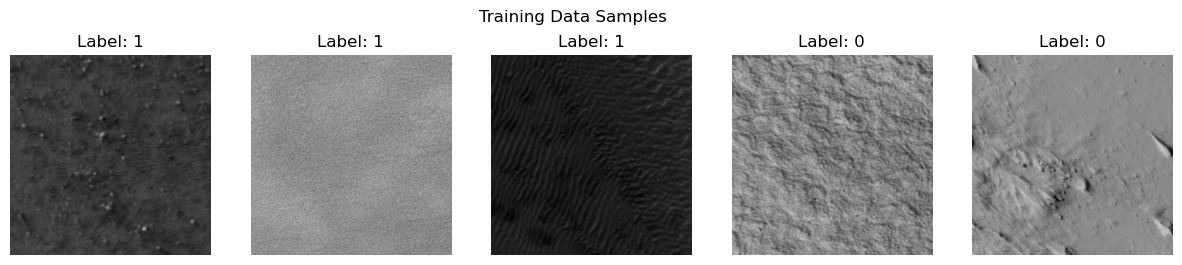

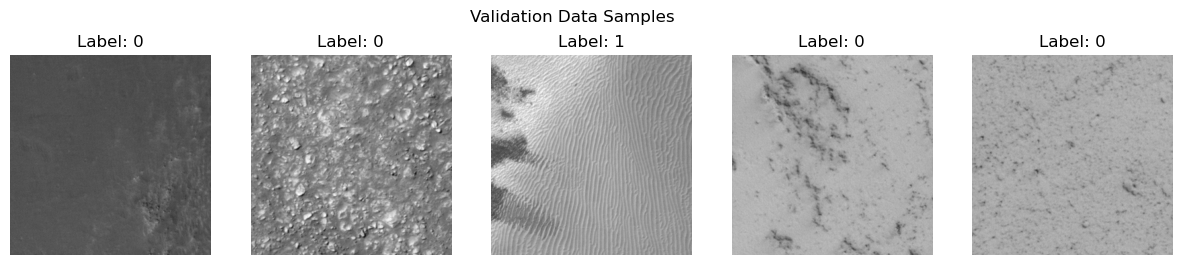

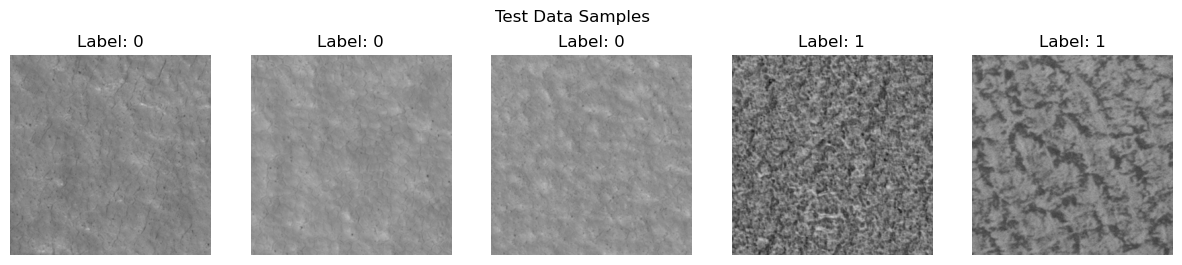

In [6]:
# display samples from each dataset
def display_dataset_samples(dataset, title, num_samples=5):
    plt.figure(figsize=(15, 3))
    plt.suptitle(title)
    for images, labels in dataset.take(num_samples):
        for i in range(num_samples):
            plt.subplot(1, num_samples, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Label: {labels[i].numpy()}")
            plt.axis("off")
    plt.show()

display_dataset_samples(tf_dataset_train, "Training Data Samples")
display_dataset_samples(tf_dataset_val, "Validation Data Samples")
display_dataset_samples(tf_dataset_test, "Test Data Samples")

### (c) Training CNN + MLP
#### i. To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

In [7]:
# randomly applied horizontal flip, random brightness, random contrast, rotations and translations
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

tf_dataset_train = tf_dataset_train.map(lambda x, y: augment(x, y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

#### ii. Train a three-layer CNN followed by a dense layer on the data. Choose the size of the kernels and depth of the layers and the number of neurons in the dense layer (MLP) on your own. Use ReLU’s in all of the layers. Use the softmax function, batch normalization and a dropout rate of 30%, L2 regularization, as well as ADAM optimizer. Use cross entropy loss. Train for at least 20 epochs and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

In [9]:
# define the model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(299, 299, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)), BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)), BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss', 
    save_best_only=True)

# compile the model
model.compile(optimizer=Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

# train the model
history = model.fit(
    tf_dataset_train,
    validation_data=tf_dataset_val,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint]
)

04:21:51 | WARNING | optimizer       | At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
04:21:51 | WARNING | optimizer       | `lr` is deprecated in Keras optimizer, please use `learning_rate` or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/20


2023-12-09 04:21:52.397067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-12-09 04:21:52.460209: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


442/442 [==============================] - ETA: 0s - loss: 5.5688 - binary_accuracy: 0.4903

/Users/erichuang/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


442/442 [==============================] - 386s 870ms/step - loss: 5.5688 - binary_accuracy: 0.4903 - val_loss: 12.4077 - val_binary_accuracy: 0.2313
Epoch 2/20
442/442 [==============================] - 301s 680ms/step - loss: 4.2705 - binary_accuracy: 0.6171 - val_loss: 4.6625 - val_binary_accuracy: 0.7694
Epoch 3/20
442/442 [==============================] - 297s 671ms/step - loss: 3.4903 - binary_accuracy: 0.6492 - val_loss: 12.6379 - val_binary_accuracy: 0.2343
Epoch 4/20
442/442 [==============================] - 292s 659ms/step - loss: 3.0424 - binary_accuracy: 0.6229 - val_loss: 13.0898 - val_binary_accuracy: 0.2339
Epoch 5/20
442/442 [==============================] - 295s 666ms/step - loss: 2.8627 - binary_accuracy: 0.6268 - val_loss: 7.6430 - val_binary_accuracy: 0.5893
Epoch 6/20
442/442 [==============================] - 296s 669ms/step - loss: 2.7984 - binary_accuracy: 0.6235 - val_loss: 5.1783 - val_binary_accuracy: 0.7693
Epoch 7/20
442/442 [============================

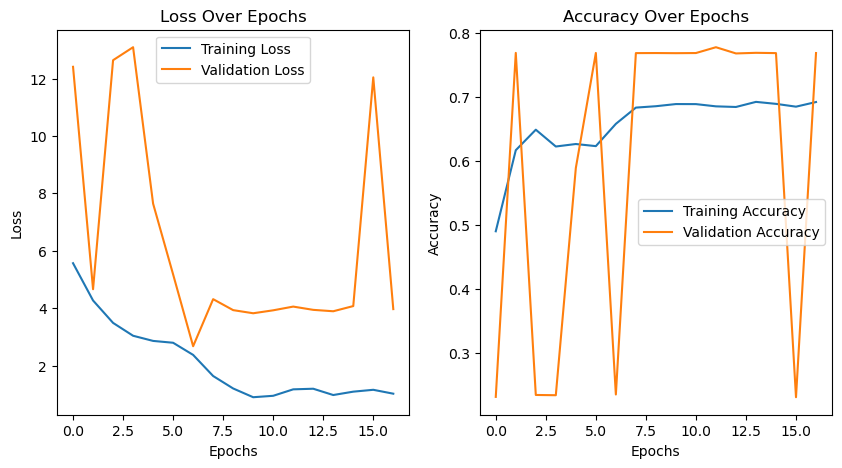

In [10]:
# plot the training and validation errors vs. epochs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### iii. Report Precision, Recall, and F1 score for your model.

In [11]:
model.load_weights('best_model.h5')

# predict on the testing dataset
test_predictions = model.predict(tf_dataset_test)
test_predictions = (test_predictions > 0.5).astype(int)
y_true = np.concatenate([y for x, y in tf_dataset_test], axis=0)

report = classification_report(y_true, test_predictions, target_names=['Background', 'Frost'])
print(report)

250/250 [==============================] - 38s 149ms/step
              precision    recall  f1-score   support

  Background       0.31      0.00      0.00      2198
       Frost       0.72      1.00      0.84      5774

    accuracy                           0.72      7972
   macro avg       0.52      0.50      0.42      7972
weighted avg       0.61      0.72      0.61      7972



### (d) Transfer Learning
#### i. When dealing with classification of relatively small image datasets, deep net- works may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those fea- tures can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. In this project, you will use pre-trained models (EfficientNetB0, ResNet50, and VGG16). For these pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.
#### ii. To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.
#### iii. Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization 5 and a dropout rate of 30% as well as ADAM optimizer. Use cross entropy loss. You can try any batch size, but a batch size of 8 seems reasonable.

In [8]:
# create a transfer learning model
def create_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy'])
    return model

# load the pre-trained models without the top layer
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False)
base_model_resnet = ResNet50(weights='imagenet', include_top=False)
base_model_vgg = VGG16(weights='imagenet', include_top=False)

# create models for each pre-trained base
model_efficientnet = create_model(base_model_efficientnet)
model_resnet = create_model(base_model_resnet)
model_vgg = create_model(base_model_vgg)

14:31:27 | WARNING | optimizer       | At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
14:31:27 | WARNING | optimizer       | `lr` is deprecated in Keras optimizer, please use `learning_rate` or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.
14:31:27 | WARNING | optimizer       | At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
14:31:27 | WARNING | optimizer       | `lr` is deprecated in Keras optimizer, please use `learning_rate` or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.
14:31:27 | WARNING | optimizer       | At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.

#### iv. Train using the features calculated by networks (EfficientNetB0, ResNet50, and VGG16) for at least 10 epochs (preferably 20 epochs) and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

Training EfficientNetB0
Epoch 1/20


2023-12-09 14:31:36.752468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-12-09 14:31:36.885527: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


442/442 [==============================] - ETA: 0s - loss: 0.6655 - binary_accuracy: 0.6385

/Users/erichuang/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


442/442 [==============================] - 318s 705ms/step - loss: 0.6655 - binary_accuracy: 0.6385 - val_loss: 1.1349 - val_binary_accuracy: 0.6568
Epoch 2/20
442/442 [==============================] - 342s 773ms/step - loss: 0.6572 - binary_accuracy: 0.6435 - val_loss: 2.4586 - val_binary_accuracy: 0.6422
Epoch 3/20
442/442 [==============================] - 340s 769ms/step - loss: 0.6544 - binary_accuracy: 0.6446 - val_loss: 2.5091 - val_binary_accuracy: 0.6472
Epoch 4/20
442/442 [==============================] - 334s 755ms/step - loss: 0.6528 - binary_accuracy: 0.6432 - val_loss: 2.3837 - val_binary_accuracy: 0.6549
Epoch 5/20
442/442 [==============================] - 325s 737ms/step - loss: 0.6538 - binary_accuracy: 0.6443 - val_loss: 2.0943 - val_binary_accuracy: 0.6671
Epoch 6/20
442/442 [==============================] - 344s 779ms/step - loss: 0.6518 - binary_accuracy: 0.6453 - val_loss: 2.6077 - val_binary_accuracy: 0.6459
Epoch 7/20
442/442 [==============================]

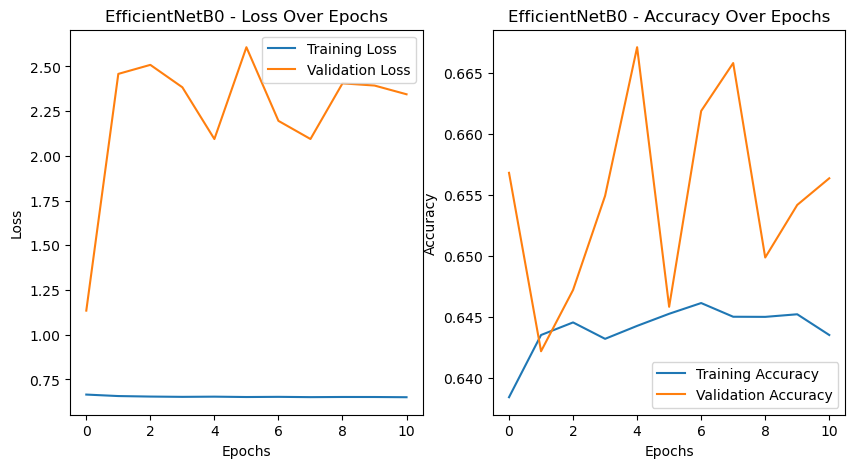

Training ResNet50
Epoch 1/20


2023-12-09 15:32:31.536387: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


442/442 [==============================] - 383s 858ms/step - loss: 0.6298 - binary_accuracy: 0.6793 - val_loss: 11.2899 - val_binary_accuracy: 0.2343
Epoch 2/20
442/442 [==============================] - 375s 848ms/step - loss: 0.6128 - binary_accuracy: 0.6881 - val_loss: 11.7262 - val_binary_accuracy: 0.2307
Epoch 3/20
442/442 [==============================] - 373s 845ms/step - loss: 0.6087 - binary_accuracy: 0.6918 - val_loss: 11.7108 - val_binary_accuracy: 0.2316
Epoch 4/20
442/442 [==============================] - 374s 846ms/step - loss: 0.6029 - binary_accuracy: 0.6976 - val_loss: 11.7213 - val_binary_accuracy: 0.2311
Epoch 5/20
442/442 [==============================] - 375s 849ms/step - loss: 0.6028 - binary_accuracy: 0.6970 - val_loss: 11.7274 - val_binary_accuracy: 0.2309
Epoch 6/20
442/442 [==============================] - 376s 851ms/step - loss: 0.6020 - binary_accuracy: 0.6937 - val_loss: 11.7261 - val_binary_accuracy: 0.2309
Epoch 7/20
442/442 [=========================

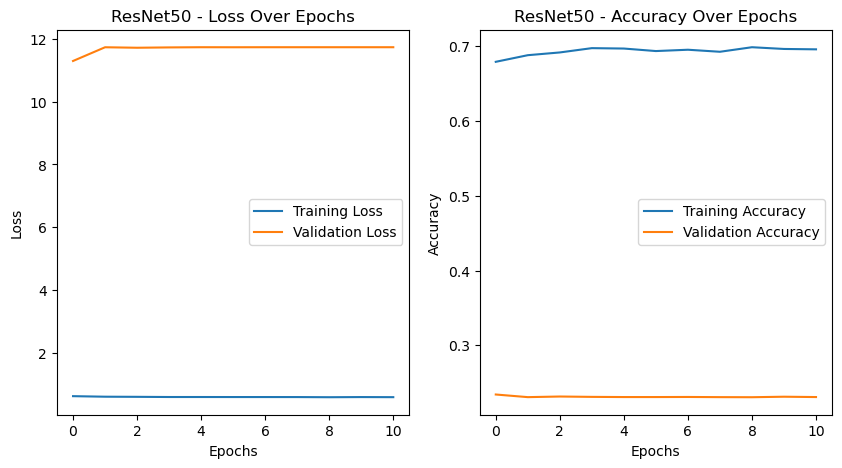

Training VGG16
Epoch 1/20


2023-12-09 16:41:23.356310: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


442/442 [==============================] - 543s 1s/step - loss: 0.5965 - binary_accuracy: 0.6978 - val_loss: 2.9978 - val_binary_accuracy: 0.7193
Epoch 2/20
442/442 [==============================] - 560s 1s/step - loss: 0.5830 - binary_accuracy: 0.7116 - val_loss: 3.8152 - val_binary_accuracy: 0.7260
Epoch 3/20
442/442 [==============================] - 546s 1s/step - loss: 0.5716 - binary_accuracy: 0.7179 - val_loss: 3.6766 - val_binary_accuracy: 0.7400
Epoch 4/20
442/442 [==============================] - 545s 1s/step - loss: 0.5754 - binary_accuracy: 0.7161 - val_loss: 3.5887 - val_binary_accuracy: 0.7515
Epoch 5/20
442/442 [==============================] - 560s 1s/step - loss: 0.5755 - binary_accuracy: 0.7144 - val_loss: 3.4617 - val_binary_accuracy: 0.7663
Epoch 6/20
442/442 [==============================] - 565s 1s/step - loss: 0.5772 - binary_accuracy: 0.7140 - val_loss: 3.3959 - val_binary_accuracy: 0.7690
Epoch 7/20
442/442 [==============================] - 566s 1s/step - 

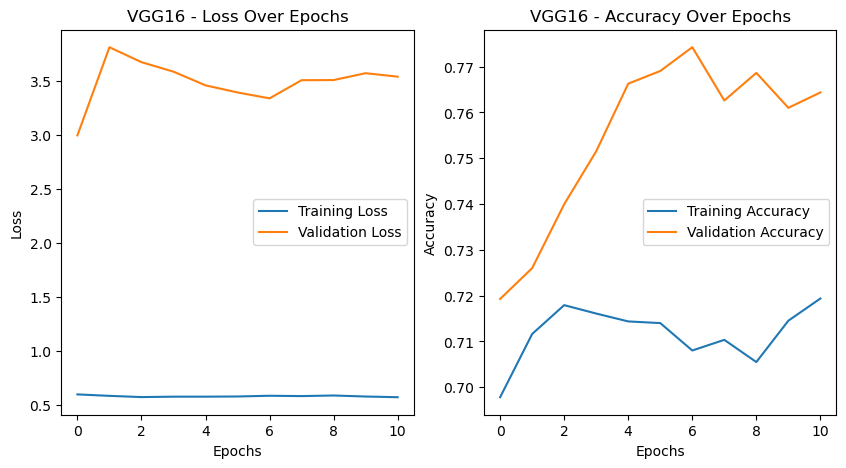

In [9]:
models = {'EfficientNetB0': model_efficientnet, 'ResNet50': model_resnet, 'VGG16': model_vgg}
history_dict = {}
checkpoint_filepath = 'best_model_{epoch}.h5'

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    checkpoint_filepath, 
    monitor='val_loss', 
    save_best_only=True)

# train the model
for name, model in models.items():
    print(f"Training {name}")
    history = model.fit(
        tf_dataset_train,
        validation_data=tf_dataset_val,
        epochs=20,
        callbacks=[early_stopping, model_checkpoint]
    )
    history_dict[name] = history
    
    # plot the training and validation errors vs. epochs
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{name} - Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.title(f'{name} - Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

#### v. Report Precision, Recall, and F1 score for your model.

In [10]:
for name, model in models.items():
    print(f"Evaluating {name}")
    
    # predict on the testing dataset
    test_predictions = model.predict(tf_dataset_test)
    test_predictions = (test_predictions > 0.5).astype(int)
    y_true = np.concatenate([y for x, y in tf_dataset_test], axis=0)

    report = classification_report(y_true, test_predictions, target_names=['Background', 'Frost'])
    print(report)

Evaluating EfficientNetB0
250/250 [==============================] - 124s 481ms/step
              precision    recall  f1-score   support

  Background       0.28      0.21      0.24      2198
       Frost       0.73      0.79      0.76      5774

    accuracy                           0.63      7972
   macro avg       0.50      0.50      0.50      7972
weighted avg       0.60      0.63      0.62      7972

Evaluating ResNet50
250/250 [==============================] - 145s 575ms/step
              precision    recall  f1-score   support

  Background       0.34      0.01      0.02      2198
       Frost       0.72      0.99      0.84      5774

    accuracy                           0.72      7972
   macro avg       0.53      0.50      0.43      7972
weighted avg       0.62      0.72      0.61      7972

Evaluating VGG16
250/250 [==============================] - 205s 818ms/step
              precision    recall  f1-score   support

  Background       0.28      0.54      0.37      21

#### vi. Compare the results of transfer learning with those of CNN + MLP model and explain them.

The transfer learning models, leveraging pre-trained networks, outperformed the custom CNN + MLP model on the Martian terrain classification task. Pre-trained features from networks like VGG16 provided a more nuanced understanding of the images, leading to higher and more balanced precision, recall, and F1 scores across classes. This demonstrates the effectiveness of transfer learning in situations where the available training data is limited, harnessing prior knowledge to achieve better generalization and performance.